# Business Analytics: Finding Potentialy Profitable Member

<!-- Creator:
- Galih Ristiantoro Widagdo
- Fathur Rahman -->

In [19]:
#import all libraries
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from mpl_toolkits import mplot3d

In [20]:
#import data
base = pd.read_csv("data/DEV_M_ACC_SIP_202206061919.csv", delimiter="|")
base.head()

,PERIOD,ACC_IDENTIFICATION,ISSUER,RECENCY,FREQUENCY,MONETARY
0,JAN-22,9360000210001934887,BRI,7,1,100.80
1,JAN-22,9360000210001935662,BRI,15,1,157.50
2,JAN-22,9360000210001938195,BRI,6,1,28.35
3,JAN-22,9360000210001940365,BRI,10,1,0.00
4,JAN-22,9360000210001941241,BRI,10,1,35.86


### Data Dictionary

- Period             : Periode kalkulasi data
- Acc Identification : Customer ID
- Issuer             : Bank sebagai Issuer
- Recency            : variabel untuk mengukur nilai pelanggan berdasarkan rentang waktu transaksi terakhir pelanggan sampai tanggal cutoff
- Frequency          : variabel untuk mengukur jumlah transaksi dalam sebuah periode
- Monetary           : variabel untuk mengukur kontribusi transaksi pada revenue, dapat menjadi CLTV (Customer Lifetime Value) apabila memiliki komponen CAC (Customer Acquisition Cost)

### Scope

- Data yang diolah adalah data Q1 2022, mungkin tidak merefleksikan keseluruhan bisnis karena data tidak mencakup keseluruhan data yang tersedia
- Data yang diolah adalah data transaksi dimana bank sebagai Issuer
- Data yang diolah merupakan data transaksi antar institusi di dalam jaringan Jalin dan transaksi antar Jaringan yang melibatkan Jalin
- Terdapat kemungkinan ketidak akurat an data yang disebabkan kurangnya data transaksi yang tidak melibatkan Jalin (contoh: transaksi antar switch Artajasa dengan Alto)

### Objective

- Mengelompokkan transaksi QRIS sesuai profile karakteristik  transaksi yang melalui jaringan Jalin.
- mencari customer yang secara potensial memberikan dampak revenue terbaik.
- Mengelola perlakuan customer untuk menjaga retensi.

In [21]:
#transformation

base_tf=base.groupby(['ISSUER']).aggregate({'RECENCY': 'median',
                             'FREQUENCY': 'sum',
                                 'MONETARY':'sum'})

In [22]:
base_tf.head()

,RECENCY,FREQUENCY,MONETARY
ISSUER,,,
APY,12.0,254212,11725058.20
ASP,13.0,3381,128964.19
BAG,12.0,891,62455.23
BAS,10.0,16923,2513740.24
BBA,15.0,7,327.33


In [23]:
#Exploratory Data Analysis
profile = ProfileReport(base_tf, title="Pandas Profiling Report", explorative=True)
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [24]:
#Scale numerical column using standartscaler

sc = StandardScaler()
base_tf[['RECENCY', 'FREQUENCY','MONETARY']] = sc.fit_transform(base_tf[['RECENCY', 'FREQUENCY','MONETARY']])
base_tf

,RECENCY,FREQUENCY,MONETARY
ISSUER,,,
APY,0.197197,0.240195,0.033328
ASP,0.507678,-0.258728,-0.236102
BAG,0.197197,-0.263681,-0.237647
BAS,-0.423764,-0.231792,-0.180693
BBA,1.128639,-0.265439,-0.239091
...,...,...,...
TMO,-0.734245,-0.251502,-0.234059
TRU,-2.597129,-0.265447,-0.239098
UOB,0.507678,-0.229864,-0.226691


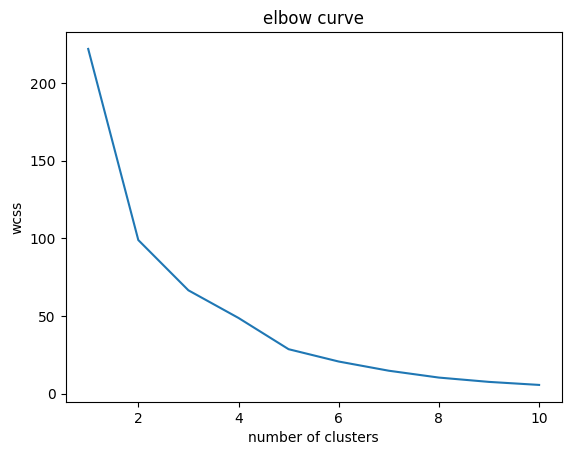

In [25]:
wcss=[]
for i in range(1,11):
    kmeans=KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(base_tf)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,11),wcss)
plt.title('elbow curve')
plt.xlabel('number of clusters')
plt.ylabel('wcss')
plt.show()

#wcss: within-cluster sum of squares (jumlah kuadrat jarak antara setiap anggota cluster dan centroidnya)

Effective cluster: 5 cluster, dimana jarak antar node ke centroid pada setiap cluster tidak terlalu jauh berbeda ketika memilih cluster > 5

In [26]:
kmeans=KMeans(n_clusters=5, init='k-means++', random_state=42)
base_tf['CLUSTER']=kmeans.fit_predict(base_tf)

base_tf

,RECENCY,FREQUENCY,MONETARY,CLUSTER
ISSUER,,,,
APY,0.197197,0.240195,0.033328,4
ASP,0.507678,-0.258728,-0.236102,4
BAG,0.197197,-0.263681,-0.237647,4
BAS,-0.423764,-0.231792,-0.180693,4
BBA,1.128639,-0.265439,-0.239091,1
...,...,...,...,...
TMO,-0.734245,-0.251502,-0.234059,0
TRU,-2.597129,-0.265447,-0.239098,0
UOB,0.507678,-0.229864,-0.226691,4


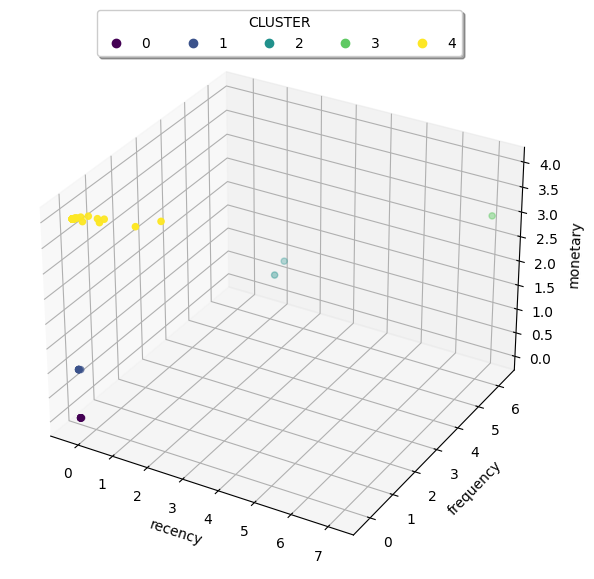

In [27]:
# Define Data

x = base_tf.iloc[:,1]
y = base_tf.iloc[:,2]
z = base_tf.iloc[:,3]
 
# Create Figure

fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
# Create Plot
ax.set_ylabel('frequency')
ax.set_xlabel('recency')
ax.set_zlabel('monetary')

sc=ax.scatter3D(x, y, z,c=z, cmap='viridis')
ax.legend(*sc.legend_elements(), title="CLUSTER",loc='upper center', 
          bbox_to_anchor=(0.5, 1.05),ncol=5, fancybox=True, shadow=True)
ax.grid(True)
# Show plot

plt.show()


In [28]:
#write to file
base_tf.to_csv("data/prediction_result.csv")

In [29]:
base_tf['R SCORE']=0+(base_tf['RECENCY']-base_tf['RECENCY'].min())*5/(base_tf['RECENCY'].max()-base_tf['RECENCY'].min())
base_tf['F SCORE']=0+(base_tf['FREQUENCY']-base_tf['FREQUENCY'].min())*5/(base_tf['FREQUENCY'].max()-base_tf['FREQUENCY'].min())
base_tf['M SCORE']=0+(base_tf['MONETARY']-base_tf['MONETARY'].min())*5/(base_tf['MONETARY'].max()-base_tf['MONETARY'].min())

base_tf['RECENCY CAT'] = pd.cut(base_tf['R SCORE'],
                              5,
                              labels=['Very Low','Low','Medium','High','Very High'])

base_tf['FREQUENCY CAT'] = pd.cut(base_tf['F SCORE'],
                              5,
                              labels=['Very Low','Low','Medium','High','Very High'])

base_tf['MONETARY CAT'] = pd.cut(base_tf['M SCORE'],
                              5,
                              labels=['Very Low','Low','Medium','High','Very High'])


base_tf['FM SCORE']=base_tf['F SCORE']+base_tf['M SCORE']
base_tf

,RECENCY,FREQUENCY,MONETARY,CLUSTER,R SCORE,F SCORE,M SCORE,RECENCY CAT,FREQUENCY CAT,MONETARY CAT,FM SCORE
ISSUER,,,,,,,,,,,
APY,0.197197,0.240195,0.033328,4,2.608696,0.341433,2.077723e-01,Medium,Very Low,Very Low,0.549205
ASP,0.507678,-0.258728,-0.236102,4,2.826087,0.004537,2.285292e-03,Medium,Very Low,Very Low,0.006822
BAG,0.197197,-0.263681,-0.237647,4,2.608696,0.001193,1.106729e-03,Medium,Very Low,Very Low,0.002299
BAS,-0.423764,-0.231792,-0.180693,4,2.173913,0.022726,4.454439e-02,Medium,Very Low,Very Low,0.067270
BBA,1.128639,-0.265439,-0.239091,1,3.260870,0.000005,5.800406e-06,High,Very Low,Very Low,0.000011
...,...,...,...,...,...,...,...,...,...,...,...
TMO,-0.734245,-0.251502,-0.234059,0,1.956522,0.009417,3.843492e-03,Low,Very Low,Very Low,0.013260
TRU,-2.597129,-0.265447,-0.239098,0,0.652174,0.000000,0.000000e+00,Very Low,Very Low,Very Low,0.000000
UOB,0.507678,-0.229864,-0.226691,4,2.826087,0.024027,9.462573e-03,Medium,Very Low,Very Low,0.033490


# Understanding the Cluster

#### Binning The RFM into Categorical Interpretation

<!-- 


|Parameter|	From|	To|	Category|Score|
|---|---|---|---|---|
|Recency|	-3,528571248|	-2,100360008|	Very High|5|
|Recency|	-2,100360008|	-0,672148768|	High|4|
|Recency|	-0,672148768|	0,756062472|	Medium|3|
|Recency|	0,756062472|	2,184273712|	Low|2|
|Recency|	2,184273712|	3,612484952|	Very Low|1|
|Frequency|	-0,265447041|	1,210413846|	Very Low|1|
|Frequency|	1,210413846|	2,686274732|	Low|2|
|Frequency|	2,686274732|	4,162135618|	Medium|3|
|Frequency|	4,162135618|	5,637996504|	High|4|
|Frequency|	5,637996504|	7,139255942|	Very High|5
|Monetary|	-0,239098204|	1,070598907|	Very Low|1|
|Monetary|	1,070598907|	2,380296018|	Low|2|
|Monetary|	2,380296018|	3,689993129|	Medium|3|
|Monetary|	3,689993129|	4,99969024|	High|4|
|Monetary|	4,99969024|	6,316788643|	Very High|5| -->

In [30]:
bank_ref=pd.read_csv("data/prediction_result_2.0.csv", delimiter=";")
bank_ref

base_tf=base_tf.merge(bank_ref,left_on='ISSUER', right_on='ISSUER')
base_tf


,ISSUER,RECENCY,FREQUENCY,MONETARY,CLUSTER,R SCORE,F SCORE,M SCORE,RECENCY CAT,FREQUENCY CAT,MONETARY CAT,FM SCORE,BANK NAME,JALIN MEMBER
0,APY,0.197197,0.240195,0.033328,4,2.608696,0.341433,2.077723e-01,Medium,Very Low,Very Low,0.549205,AIRPAY,NO
1,ASP,0.507678,-0.258728,-0.236102,4,2.826087,0.004537,2.285292e-03,Medium,Very Low,Very Low,0.006822,ASTRAPAY,NO
2,BAG,0.197197,-0.263681,-0.237647,4,2.608696,0.001193,1.106729e-03,Medium,Very Low,Very Low,0.002299,BANK ARTHA GRAHA,NO
3,BAS,-0.423764,-0.231792,-0.180693,4,2.173913,0.022726,4.454439e-02,Medium,Very Low,Very Low,0.067270,ACEH,YES
4,BBA,1.128639,-0.265439,-0.239091,1,3.260870,0.000005,5.800406e-06,High,Very Low,Very Low,0.000011,BANK BUMI ARTA,NO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,TMO,-0.734245,-0.251502,-0.234059,0,1.956522,0.009417,3.843492e-03,Low,Very Low,Very Low,0.013260,TMONEY,YES
70,TRU,-2.597129,-0.265447,-0.239098,0,0.652174,0.000000,0.000000e+00,Very Low,Very Low,Very Low,0.000000,TRUEMONEY,NO
71,UOB,0.507678,-0.229864,-0.226691,4,2.826087,0.024027,9.462573e-03,Medium,Very Low,Very Low,0.033490,UOB,NO
72,YUK,-0.423764,-0.263818,-0.238409,4,2.173913,0.001100,5.258784e-04,Medium,Very Low,Very Low,0.001626,YUKK,YES


# Business Insights

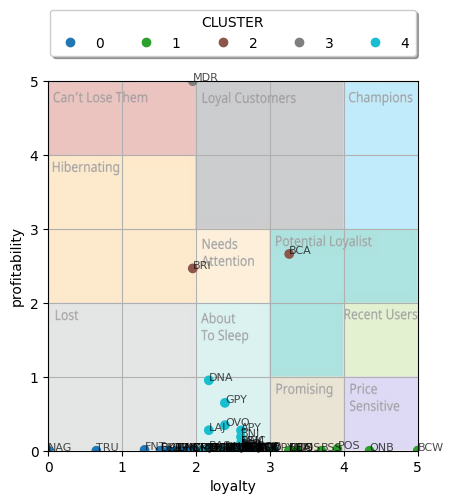

In [31]:
# Base RFM matrix layer
layer_img=plt.imread("assets/rfm.JPG")

# Define Data

x = base_tf.iloc[:,5] #R Score
y = base_tf.iloc[:,11]/2 #FM Score -> divided to half to normalize with R Score
extent = (0,5, 0, 5) #tupple resizer

# Create Figure

fig, ax = plt.subplots()
ax.set_ylabel('profitability')
ax.set_xlabel('loyalty')
sc=ax.scatter(x, y,c=z, cmap='tab10', alpha=1,zorder=2)
ax.legend(*sc.legend_elements(), title="CLUSTER",loc='lower center', 
          bbox_to_anchor=(0.5, 1.05),ncol=5, fancybox=True, shadow=True)
ax.grid(True)
plt.imshow(layer_img,zorder=1, extent=extent, alpha=0.4)
for i, label in enumerate(base_tf['ISSUER']):
    plt.annotate(label, (x[i], y[i]),alpha=0.7,size=8)
plt.show()

#### Cluster 0

Criteria: Lost\
Summary: Tidak terdapat sebaran transaksi, jumlah transaksi, dan kontribusi revenue yang signifikan dalam sebuah periode\
\
Actionable Insight:
- Revive interest, reach out customer using campaign

In [32]:
base_tf.loc[base_tf['CLUSTER']==0]

,ISSUER,RECENCY,FREQUENCY,MONETARY,CLUSTER,R SCORE,F SCORE,M SCORE,RECENCY CAT,FREQUENCY CAT,MONETARY CAT,FM SCORE,BANK NAME,JALIN MEMBER
9,BKP,-1.355206,-0.265135,-0.238982,0,1.521739,0.000211,8.843985e-05,Low,Very Low,Very Low,0.000299,BANK KB BUKOPIN,NO
21,DKI,-0.734245,-0.261821,-0.237307,0,1.956522,0.002449,1.366472e-03,Low,Very Low,Very Low,0.003815,BANK DKI,NO
27,FLO,-1.355206,-0.264108,-0.238991,0,1.521739,0.000904,8.191326e-05,Low,Very Low,Very Low,0.000986,FELLO,YES
28,FNT,-1.665687,-0.240048,-0.231697,0,1.304348,0.017150,5.644768e-03,Low,Very Low,Very Low,0.022795,FINNET,YES
29,GNS,-1.044726,-0.263721,-0.238758,0,1.739130,0.001166,2.597109e-04,Low,Very Low,Very Low,0.001426,BANK GANESHA,NO
33,IMK,-1.044726,-0.264387,-0.238880,0,1.739130,0.000716,1.664982e-04,Low,Very Low,Very Low,0.000882,IMKAS INDOSAT,NO
41,KTA,-0.734245,-0.263486,-0.237765,0,1.956522,0.001324,1.017141e-03,Low,Very Low,Very Low,0.002341,BANK BPD KALTIMTARA,NO
49,MYR,-0.889485,-0.265405,-0.239070,0,1.847826,0.000028,2.125487e-05,Low,Very Low,Very Low,0.000049,BANK MAYORA,NO
50,NAG,-3.528571,-0.262217,-0.236793,0,0.000000,0.002181,1.757955e-03,Very Low,Very Low,Very Low,0.003939,BANK NAGARI,NO
59,PAP,-1.199966,-0.265288,-0.238989,0,1.630435,0.000107,8.328695e-05,Low,Very Low,Very Low,0.000191,BANK PAPUA,NO


#### Cluster 1

Criteria: New Customers\
Summary: Customer baru-baru ini melakukan transaksi, namun frekuensi transaksi dan kontribusi revenue tidak signifikan\
\
Actionable Insight:
- Provide onboarding support, give them early success, start building relationship

In [33]:
base_tf.loc[base_tf['CLUSTER']==1]

,ISSUER,RECENCY,FREQUENCY,MONETARY,CLUSTER,R SCORE,F SCORE,M SCORE,RECENCY CAT,FREQUENCY CAT,MONETARY CAT,FM SCORE,BANK NAME,JALIN MEMBER
4,BBA,1.128639,-0.265439,-0.239091,1,3.260870,0.000005,0.000006,High,Very Low,Very Low,0.000011,BANK BUMI ARTA,NO
8,BCW,3.612485,-0.260186,-0.237208,1,5.000000,0.003553,0.001442,Very High,Very Low,Very Low,0.004994,BANK COMMONWEALTH,NO
10,BMS,1.283880,-0.261513,-0.236458,1,3.369565,0.002657,0.002014,High,Very Low,Very Low,0.004670,BIMASAKTI,YES
16,BSS,1.749601,-0.264343,-0.238646,1,3.695652,0.000745,0.000345,High,Very Low,Very Low,0.001090,BANK SAMPOERNA,NO
47,MUS,1.128639,-0.265216,-0.238964,1,3.260870,0.000156,0.000102,High,Very Low,Very Low,0.000258,MULTIARTA SENTOSA,NO
57,OTO,1.128639,-0.265218,-0.239047,1,3.260870,0.000154,0.000039,High,Very Low,Very Low,0.000194,OTTOCASH,NO
61,POS,2.060081,-0.220713,-0.216860,1,3.913043,0.030207,0.016960,High,Very Low,Very Low,0.047167,POS,YES
65,QNB,2.681043,-0.265387,-0.239054,1,4.347826,0.000040,0.000034,Very High,Very Low,Very Low,0.000074,BANK QNB INDONESIA,NO


#### Cluster 2

Criteria: Need Attention - Potential Loyalist\
Summary: Customer baru-baru ini melakukan transaksi, jumlah dan kontribusi revenue signifikan\
\
Actionable Insight:
- Offer interesting program to boost transaction\
\
\
Finding:
- Transaksi BCA masuk kedalam karakteristik cluster ini, saat ini BCA belum menjadi member Jalin, apabila Jalin dapat mengakuisisi BCA sebagai member maka proyeksi revenue QR Domestik dapat bertumbuh  yang disumbang dari transaksi On-Net.
- Dengan mengakuisisi BCA sebagai member Jalin, maka dapat meningkatkan potensi revenue dari transaksi Off-Net ke switching lain yang sebelumnya tidak melalui Jalin.

In [34]:
base_tf.loc[base_tf['CLUSTER']==2]

,ISSUER,RECENCY,FREQUENCY,MONETARY,CLUSTER,R SCORE,F SCORE,M SCORE,RECENCY CAT,FREQUENCY CAT,MONETARY CAT,FM SCORE,BANK NAME,JALIN MEMBER
5,BCA,1.128639,2.607288,4.197157,2,3.260870,1.939805,3.383414,High,Low,High,5.323218,BCA,NO
13,BRI,-0.734245,2.751861,3.556755,2,1.956522,2.037427,2.894996,Low,Medium,Medium,4.932422,BRI,YES


#### Cluster 3

Criteria: Loyal Customers\
Summary: Customer baru-baru ini melakukan transaksi, jumlah dan kontribusi revenue sangat signifikan\
\
Actionable Insight:
- Upsell higher product, Cross sell complimentary product, provide engagement

In [35]:
base_tf.loc[base_tf['CLUSTER']==3]

,ISSUER,RECENCY,FREQUENCY,MONETARY,CLUSTER,R SCORE,F SCORE,M SCORE,RECENCY CAT,FREQUENCY CAT,MONETARY CAT,FM SCORE,BANK NAME,JALIN MEMBER
44,MDR,-0.734245,7.139256,6.316789,3,1.956522,5.0,5.0,Low,Very High,Very High,10.0,MANDIRI,YES


#### Cluster 4

Criteria: About to sleep\
Summary: Customer baru-baru ini tidak melakukan transaksi, jumlah dan kontribusi tidak signifikan\
\
Actionable Insight:
- Share valuable program, reconnect with members

In [36]:
base_tf.loc[base_tf['CLUSTER']==4]

,ISSUER,RECENCY,FREQUENCY,MONETARY,CLUSTER,R SCORE,F SCORE,M SCORE,RECENCY CAT,FREQUENCY CAT,MONETARY CAT,FM SCORE,BANK NAME,JALIN MEMBER
0,APY,0.197197,0.240195,0.033328,4,2.608696,0.341433,0.207772,Medium,Very Low,Very Low,0.549205,AIRPAY,NO
1,ASP,0.507678,-0.258728,-0.236102,4,2.826087,0.004537,0.002285,Medium,Very Low,Very Low,0.006822,ASTRAPAY,NO
2,BAG,0.197197,-0.263681,-0.237647,4,2.608696,0.001193,0.001107,Medium,Very Low,Very Low,0.002299,BANK ARTHA GRAHA,NO
3,BAS,-0.423764,-0.231792,-0.180693,4,2.173913,0.022726,0.044544,Medium,Very Low,Very Low,0.067270,ACEH,YES
6,BCD,0.507678,-0.240520,-0.210787,4,2.826087,0.016832,0.021592,Medium,Very Low,Very Low,0.038424,BANK DIGITAL BCA,NO
7,BCS,0.197197,-0.263713,-0.237416,4,2.608696,0.001171,0.001283,Medium,Very Low,Very Low,0.002454,BANK BCA SYARIAH,NO
11,BMT,-0.423764,-0.265216,-0.239077,4,2.173913,0.000156,0.000016,Medium,Very Low,Very Low,0.000172,BMT,NO
12,BNI,0.197197,-0.014724,0.029863,4,2.608696,0.169300,0.205130,Medium,Very Low,Very Low,0.374430,BNI,NO
14,BRY,0.352438,-0.264854,-0.238851,4,2.717391,0.000400,0.000189,Medium,Very Low,Very Low,0.000589,BANK RAYA,YES
15,BSM,0.197197,-0.143576,-0.083506,4,2.608696,0.082293,0.118666,Medium,Very Low,Very Low,0.200959,BSM,NO
